# Code to analyse the outputs from Token Classification tasks

## Imports

In [25]:
from typing import List, Optional, Dict
from dataclasses import dataclass
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import Counter


## Constants

- TODO: the ALL_LABELS will depend on model/dataset
- TODO: sort the ALL_LABELS in a config file or here, to avoid errors in id2label code etc.

In [8]:
ALL_LABELS = sorted(["PERSON", "LOCATION", "ORGANIZATION", "MISC"])

IOB2_LABELS = ["O"] + [f"{prefix}-{label}" for label in ALL_LABELS for prefix in ["B", "I"]]

## Classes

- TODO: optimise the zips, we iterate once for each metric for now

In [9]:
@dataclass
class SamplePrediction:
    text: str
    tokens: List[str]
    reference_labels: List[str]
    predicted_labels: List[str]
    token_offsets: Optional[List[tuple]] = None  # (start, end) char offsets for each token

    def token_level_accuracy(self) -> float:
        correct = sum(p == r for p, r in zip(self.predicted_labels, self.reference_labels))
        total = len(self.reference_labels)
        return correct / total if total > 0 else 0.0

    def token_level_metrics(self) -> Dict[str, Dict[str, float]]:
        """
        Compute precision, recall, F1 for each IOB2 label (excluding 'O').
        Returns a dict: {label: {'precision':..., 'recall':..., 'f1':...}}
        """
        metrics = {}
        for label in IOB2_LABELS:
            if label == "O":
                continue  # Usually we skip 'O' for per-entity metrics
            
            tp = sum((p == label) and (r == label) for p, r in zip(self.predicted_labels, self.reference_labels))
            fp = sum((p == label) and (r != label) for p, r in zip(self.predicted_labels, self.reference_labels))
            fn = sum((p != label) and (r == label) for p, r in zip(self.predicted_labels, self.reference_labels))
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
            
            metrics[label] = {"precision": precision,
                              "recall": recall,
                              "f1": f1}
            
        return metrics

## Samples

In [10]:
# Dummy example with subwords
sample = SamplePrediction(
    text="Jonathan visited Newcastle.",
    tokens=["Johan", "##th", "##an", "visited", "New", "##castle", "."],
    reference_labels=[
        "B-PERSON", "I-PERSON", "I-PERSON",  # Jonathan
        "O",                                 # visited
        "B-LOCATION", "I-LOCATION",          # Newcastle
        "O"                                  # .
    ],
    predicted_labels=[
        "B-PERSON", "I-PERSON", "I-PERSON",  # Jonathan
        "O",                                 # visited
        "B-LOCATION", "I-LOCATION",          # Newcastle
        "O"                                  # .
    ]
)

In [11]:
print(sample)

SamplePrediction(text='Jonathan visited Newcastle.', tokens=['Johan', '##th', '##an', 'visited', 'New', '##castle', '.'], reference_labels=['B-PERSON', 'I-PERSON', 'I-PERSON', 'O', 'B-LOCATION', 'I-LOCATION', 'O'], predicted_labels=['B-PERSON', 'I-PERSON', 'I-PERSON', 'O', 'B-LOCATION', 'I-LOCATION', 'O'], token_offsets=None)


In [12]:
print("Token-level accuracy:", sample.token_level_accuracy())
print("Token-level metrics:")
for label, m in sample.token_level_metrics().items():
    print(f"  {label}: {m}")

Token-level accuracy: 1.0
Token-level metrics:
  B-LOCATION: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
  I-LOCATION: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
  B-MISC: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
  I-MISC: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
  B-ORGANIZATION: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
  I-ORGANIZATION: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
  B-PERSON: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
  I-PERSON: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


In [13]:
complicated_sample = SamplePrediction(
    text="Jonathan Smith visited New York and met Dr. Alice Johnson.",
    tokens=[
        "Johan", "##th", "##an", "Smith",      # Jonathan Smith
        "visited",                            # visited
        "New", "York",                        # New York
        "and", "met",                         # and met
        "Dr", ".", "Alice", "Johnson", "."    # Dr. Alice Johnson.
    ],
    reference_labels=[
        "B-PERSON", "I-PERSON", "I-PERSON", "I-PERSON",   # Jonathan Smith
        "O",                                              # visited
        "B-LOCATION", "I-LOCATION",                       # New York
        "O", "O",                                         # and met
        "B-PERSON", "I-PERSON", "I-PERSON", "I-PERSON",   # Dr. Alice Johnson
        "O"                                               # .
    ],
    predicted_labels=[
        "B-PERSON", "I-PERSON", "I-PERSON", "B-LOCATION", # Smith misclassified as B-LOCATION
        "O",                                              # visited
        "B-LOCATION", "I-LOCATION",                       # New York
        "O", "O",                                         # and met
        "B-PERSON", "I-PERSON", "B-PERSON", "O",          # Alice Johnson misclassified
        "O"                                               # .
    ]
)

print("Token-level accuracy:", complicated_sample.token_level_accuracy())
print("Token-level metrics:")
for label, m in complicated_sample.token_level_metrics().items():
    print(f"  {label}: {m}")


Token-level accuracy: 0.7857142857142857
Token-level metrics:
  B-LOCATION: {'precision': 0.5, 'recall': 1.0, 'f1': 0.6666666666666666}
  I-LOCATION: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
  B-MISC: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
  I-MISC: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
  B-ORGANIZATION: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
  I-ORGANIZATION: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
  B-PERSON: {'precision': 0.6666666666666666, 'recall': 1.0, 'f1': 0.8}
  I-PERSON: {'precision': 1.0, 'recall': 0.5, 'f1': 0.6666666666666666}


## Experiment manager class

Here is where I'll store the collection of SamplePredictions and add methods to evaluate a run across several such Samples

---

- for the plot: Normalization by row (so each row sums to 1, showing per-class error rates)

In [26]:
import pandas as pd
from typing import List

class ExperimentManager:
    def __init__(self, samples: List[SamplePrediction]):
        self.samples = samples

    def get_confusion_matrix(self) -> pd.DataFrame:
        all_refs = []
        all_preds = []
        for sample in self.samples:
            all_refs.extend(sample.reference_labels)
            all_preds.extend(sample.predicted_labels)
        cm = pd.crosstab(
            pd.Series(all_refs, name="Reference"),
            pd.Series(all_preds, name="Predicted"),
            rownames=["Reference"], colnames=["Predicted"],
            dropna=False
        )
        cm = cm.reindex(index=IOB2_LABELS, columns=IOB2_LABELS, fill_value=0)
        return cm

    def plot_confusion_matrix(self, normalize: bool = True):
        cm = self.get_confusion_matrix()

        # avoid this error:
        # RuntimeWarning: invalid value encountered in less xa[xa < 0] = -1
        if normalize:
            cm = cm.div(cm.sum(axis=1).replace(0, np.nan), axis=0)
            cm = cm.fillna(0)  # Replace NaNs with zeros
            
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm, annot=True, fmt=".2f" if normalize else "d",
            cmap="viridis", cbar=True,
            xticklabels=IOB2_LABELS, yticklabels=IOB2_LABELS
        )
        plt.xlabel("Predicted")
        plt.ylabel("Reference")
        plt.title("Token-level Confusion Matrix" + (" (Normalized)" if normalize else ""))
        plt.tight_layout()
        plt.show()
    
    def entity_level_metrics(self):
        tp, fp, fn = Counter(), Counter(), Counter()
        for sample in self.samples:
            ref_entities = set(extract_entities(sample.reference_labels))
            pred_entities = set(extract_entities(sample.predicted_labels))
            for entity in pred_entities:
                if entity in ref_entities:
                    tp[entity[0]] += 1
                else:
                    fp[entity[0]] += 1
            for entity in ref_entities:
                if entity not in pred_entities:
                    fn[entity[0]] += 1
        results = {}
        for label in ALL_LABELS:
            precision = tp[label] / (tp[label] + fp[label]) if (tp[label] + fp[label]) > 0 else 0.0
            recall = tp[label] / (tp[label] + fn[label]) if (tp[label] + fn[label]) > 0 else 0.0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
            results[label] = {"precision": precision, "recall": recall, "f1": f1}
        return results


# Example usage with two samples
samples = [sample, complicated_sample]


# Example usage:
manager = ExperimentManager(samples)

confusion_matrix = manager.get_confusion_matrix()

print(confusion_matrix)

Predicted       O  B-LOCATION  I-LOCATION  B-MISC  I-MISC  B-ORGANIZATION  \
Reference                                                                   
O               6           0           0       0       0               0   
B-LOCATION      0           2           0       0       0               0   
I-LOCATION      0           0           2       0       0               0   
B-MISC          0           0           0       0       0               0   
I-MISC          0           0           0       0       0               0   
B-ORGANIZATION  0           0           0       0       0               0   
I-ORGANIZATION  0           0           0       0       0               0   
B-PERSON        0           0           0       0       0               0   
I-PERSON        1           1           0       0       0               0   

Predicted       I-ORGANIZATION  B-PERSON  I-PERSON  
Reference                                           
O                            0         0      

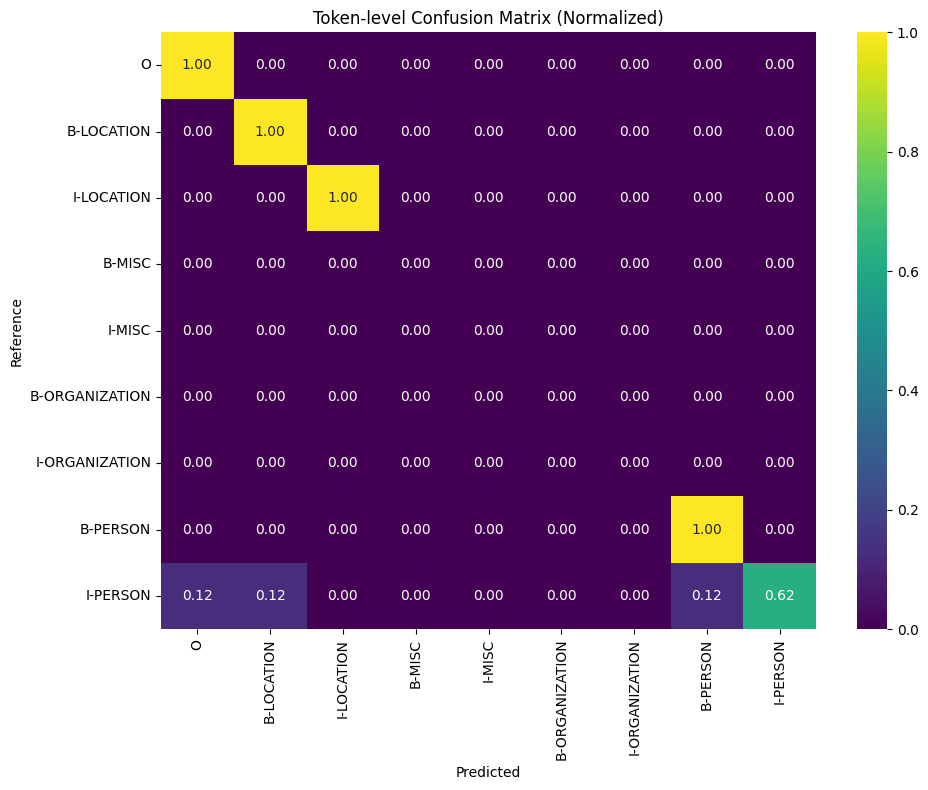

In [22]:
manager.plot_confusion_matrix(normalize=True)

## Entity level evaluation

In [23]:
def extract_entities(labels: List[str]) -> List[tuple]:
    """
    Extract entities from IOB2 labels.
    Returns a list of (entity_type, start_idx, end_idx) tuples.
    """
    entities = []
    entity_type = None
    start = None
    
    for i, label in enumerate(labels):
        if label.startswith("B-"):
            if entity_type is not None:
                entities.append((entity_type, start, i-1))
            entity_type = label[2:]
            start = i
        elif label.startswith("I-") and entity_type == label[2:]:
            continue
        else:
            if entity_type is not None:
                entities.append((entity_type, start, i-1))
                entity_type = None
                start = None
    
    if entity_type is not None:
        entities.append((entity_type, start, len(labels)-1))
    
    return entities

In [27]:
# Use the complicated_sample from earlier
print("Tokens:", complicated_sample.tokens)
print("Reference labels:", complicated_sample.reference_labels)
print("Predicted labels:", complicated_sample.predicted_labels)

Tokens: ['Johan', '##th', '##an', 'Smith', 'visited', 'New', 'York', 'and', 'met', 'Dr', '.', 'Alice', 'Johnson', '.']
Reference labels: ['B-PERSON', 'I-PERSON', 'I-PERSON', 'I-PERSON', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'B-PERSON', 'I-PERSON', 'I-PERSON', 'I-PERSON', 'O']
Predicted labels: ['B-PERSON', 'I-PERSON', 'I-PERSON', 'B-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'B-PERSON', 'I-PERSON', 'B-PERSON', 'O', 'O']


In [28]:
ref_entities = extract_entities(complicated_sample.reference_labels)
pred_entities = extract_entities(complicated_sample.predicted_labels)

print("\nExtracted reference entities:")
for ent in ref_entities:
    print(f"  Type: {ent[0]}, Tokens: {complicated_sample.tokens[ent[1]:ent[2]+1]} (indexes {ent[1]}-{ent[2]})")

print("\nExtracted predicted entities:")
for ent in pred_entities:
    print(f"  Type: {ent[0]}, Tokens: {complicated_sample.tokens[ent[1]:ent[2]+1]} (indexes {ent[1]}-{ent[2]})")


Extracted reference entities:
  Type: PERSON, Tokens: ['Johan', '##th', '##an', 'Smith'] (indexes 0-3)
  Type: LOCATION, Tokens: ['New', 'York'] (indexes 5-6)
  Type: PERSON, Tokens: ['Dr', '.', 'Alice', 'Johnson'] (indexes 9-12)

Extracted predicted entities:
  Type: PERSON, Tokens: ['Johan', '##th', '##an'] (indexes 0-2)
  Type: LOCATION, Tokens: ['Smith'] (indexes 3-3)
  Type: LOCATION, Tokens: ['New', 'York'] (indexes 5-6)
  Type: PERSON, Tokens: ['Dr', '.'] (indexes 9-10)
  Type: PERSON, Tokens: ['Alice'] (indexes 11-11)


# WIP

currently at: Add extract_entities as a static method or utility function

---

# Update - v2

I need to extend the SamplePrediction I want to include the stuff about the raw text and the spans etc.

Also the full model output before argmax

In [29]:
from typing import List, Dict, Optional
import numpy as np

class SamplePrediction:
    def __init__(
        self,
        source_text: str,
        span_annotations: List[Dict],  # Each dict: {"start": int, "end": int, "label": str}
        model_tokens: List[str],
        reference_labels: List[str],
        predicted_labels: Optional[List[str]] = None,
        full_model_output: Optional[np.ndarray] = None,  # shape: (len(model_tokens), num_labels)
        word_ids: Optional[List[Optional[int]]] = None,  # mapping from model_tokens to word indices
    ):
        self.source_text = source_text
        self.span_annotations = span_annotations
        self.model_tokens = model_tokens
        self.reference_labels = reference_labels
        self.predicted_labels = predicted_labels
        self.full_model_output = full_model_output
        self.word_ids = word_ids  # Useful for subword-to-word aggregation

    # Add methods for mapping, aggregation, etc., as needed

### Example

In [38]:
"Johnathan Smith visited New York to work at Microsoft."[0:15]

'Johnathan Smith'

In [39]:
"Johnathan Smith visited New York to work at Microsoft."[24:32]

'New York'

In [43]:
"Johnathan Smith visited New York to work at Microsoft."[44:53]

'Microsoft'

In [30]:
sample = SamplePrediction(
    source_text="Johnathan Smith visited New York to work at Microsoft.",
    span_annotations=[
        {"start": 0, "end": 15, "label": "PERSON"},      # "Johnathan Smith"
        {"start": 24, "end": 32, "label": "LOCATION"},   # "New York"
        {"start": 44, "end": 53, "label": "ORG"},        # "Microsoft"
    ],
    model_tokens=[
        "Johna", "##than", "Smith", "visited", "New", "York", "to", "work", "at", "Micro", "##soft", "."
    ],
    reference_labels=[
        "B-PERSON", "I-PERSON", "I-PERSON", "O", "B-LOCATION", "I-LOCATION",
        "O", "O", "O", "B-ORG", "I-ORG", "O"
    ],
    predicted_labels=[
        "B-PERSON", "I-PERSON", "I-PERSON", "O", "B-LOCATION", "I-LOCATION",
        "O", "O", "O", "B-ORG", "I-ORG", "O"
    ],
    full_model_output=np.random.rand(12, 7),  # 12 tokens, 7 labels
    word_ids=[0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8]
)

In [46]:
print(sample.full_model_output)

[[0.9245421  0.22599987 0.50717619 0.33707583 0.35214706 0.78986202
  0.21370254]
 [0.60098835 0.23232804 0.38806825 0.13600005 0.72842439 0.17823096
  0.68412676]
 [0.3595796  0.51964548 0.42446116 0.76484363 0.72870393 0.91475005
  0.63298518]
 [0.04039692 0.75773467 0.62850169 0.81644773 0.0631954  0.34131688
  0.68092087]
 [0.84729984 0.50045177 0.94972323 0.42664894 0.04258853 0.37626646
  0.01529994]
 [0.36135649 0.54666145 0.86219493 0.54007263 0.64587343 0.61644922
  0.67917831]
 [0.07919571 0.87535139 0.92398862 0.89630468 0.10908365 0.24574663
  0.94303102]
 [0.92879558 0.57377266 0.0537219  0.57629327 0.18511432 0.86764646
  0.58210999]]


---

1. Problem Recap

Given:

model_tokens (may include subwords)
word_ids (maps each token to its original word index)
predicted_labels (IOB2 label for each token, possibly inconsistent for subwords of the same word)
Goal:
Aggregate subword predictions to assign a single label per word, using a robust strategy.

In [1]:
def aggregate_subword_predictions_to_words(model_tokens, word_ids, predicted_labels):
    """
    Aggregates subword-level predictions to word-level using the first subword strategy.
    Returns a list of (word, label) pairs.
    """
    word_to_first_token = {}
    for idx, wid in enumerate(word_ids):
        if wid is not None and wid not in word_to_first_token:
            word_to_first_token[wid] = idx

    # Get unique word indices in order
    unique_word_ids = [wid for wid in sorted(set(w for w in word_ids if w is not None))]

    word_level_labels = []
    for wid in unique_word_ids:
        first_token_idx = word_to_first_token[wid]
        label = predicted_labels[first_token_idx]
        # Reconstruct the word from its tokens
        word_tokens = [model_tokens[i] for i, w in enumerate(word_ids) if w == wid]
        # Join subwords (simple version, for demonstration)
        word = "".join([t.replace("##", "") if t.startswith("##") else t for t in word_tokens])
        word_level_labels.append((word, label))
    return word_level_labels



In [3]:
model_tokens = ["Johna", "##than", "Smith", "visited", "New", "York", "to", "work", "at", "Micro", "##soft", "."]
word_ids     = [    0,        0,       1,        2,     3,      4,    5,     6,     7,      8,        8,    9]
predicted_labels = [
    "B-PERSON", "O", "I-PERSON", "O", "B-LOCATION", "I-LOCATION",
    "O", "O", "O", "B-ORG", "O", "O"
]


# Example usage:
word_level = aggregate_subword_predictions_to_words(model_tokens, word_ids, predicted_labels)
for word, label in word_level:
    print(f"{word}: {label}")

Johnathan: B-PERSON
Smith: I-PERSON
visited: O
New: B-LOCATION
York: I-LOCATION
to: O
work: O
at: O
Microsoft: B-ORG
.: O


## Entity extraction from word level stuff now

In [4]:
def extract_entities_from_word_labels(word_level_labels):
    """
    Given a list of (word, label) pairs, extract entities as (entity_type, start_idx, end_idx, entity_text).
    start_idx and end_idx are word indices (inclusive, exclusive).
    """
    entities = []
    entity_type = None
    entity_start = None
    entity_words = []

    for idx, (word, label) in enumerate(word_level_labels):
        if label.startswith("B-"):
            # Close previous entity if any
            if entity_type is not None:
                entities.append((entity_type, entity_start, idx, " ".join(entity_words)))
            # Start new entity
            entity_type = label[2:]
            entity_start = idx
            entity_words = [word]
        elif label.startswith("I-") and entity_type == label[2:]:
            entity_words.append(word)
        else:
            # Close previous entity if any
            if entity_type is not None:
                entities.append((entity_type, entity_start, idx, " ".join(entity_words)))
                entity_type = None
                entity_start = None
                entity_words = []
            # No entity, continue

    # Close any remaining entity
    if entity_type is not None:
        entities.append((entity_type, entity_start, len(word_level_labels), " ".join(entity_words)))

    return entities


In [5]:
# Example usage:
entities = extract_entities_from_word_labels(word_level)
for ent in entities:
    print(f"Entity: {ent[3]!r}, Type: {ent[0]}, Words: {ent[1]}-{ent[2]-1}")

Entity: 'Johnathan Smith', Type: PERSON, Words: 0-1
Entity: 'New York', Type: LOCATION, Words: 3-4
Entity: 'Microsoft', Type: ORG, Words: 8-8
